In [31]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition
import pickle

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [32]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
with open('reddit_submissions_min_tkns.pkl', 'rb') as f:
    reddit_submissions_min = pickle.load(f)

## Exercise 2: Using Multinomial Logistic and Naive Bayes to classify Reddit posts by subreddit

### Reading (and pickling) the data

In [2]:
reddit_submissions_raw = pandas.read_csv('../project_data/reddit_submissions_2015_18.csv', index_col=6)

/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
reddit_submissions_min = reddit_submissions_raw[['author', 'created_utc', 'subreddit', 'title', 'selftext', 'distinguished']]
reddit_submissions_min = reddit_submissions_raw[-reddit_submissions_raw['subreddit'].isin(['altright', 'Republican'])]
reddit_submissions_min = reddit_submissions_min.groupby('subreddit')
reddit_submissions_min = reddit_submissions_min.apply(lambda x: x.sample(reddit_submissions_min.size().min()).reset_index(drop=True))
reddit_submissions_min['subreddit'].value_counts()

KotakuInAction    1891
Incels            1891
Conservative      1891
The_Donald        1891
Name: subreddit, dtype: int64

In [8]:
reddit_submissions_min.reset_index(inplace = True, drop = True)
len(reddit_submissions_min)

7564

In [10]:
reddit_submissions_min['post_text'] = reddit_submissions_min['title'] + " " + reddit_submissions_min['selftext']

In [11]:
reddit_submissions_min['tokenized_text'] = reddit_submissions_min['post_text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
reddit_submissions_min['normalized_text'] = reddit_submissions_min['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [12]:
reddit_submissions_min.head()

,level_1,author,author_created_utc,author_fullname,created_utc,domain,full_link,is_self,locked,num_comments,score,selftext,stickied,subreddit,title,distinguished,post_text,tokenized_text,normalized_text
0,0,finsnfeathers,1.387482e+09,t2_efknk,1478730996,self.Conservative,https://www.reddit.com/r/Conservative/comments...,True,False,31,97,The mods of all subs need to crack down own th...,False,Conservative,It's bullshit that I can only post my beliefs ...,NaN,It's bullshit that I can only post my beliefs ...,"[It, 's, bullshit, that, I, can, only, post, m...","[bullshit, post, belief, like, sub, reddit, lo..."
1,1,trekie140,1.458073e+09,t2_wexsh,1478750588,self.Conservative,https://www.reddit.com/r/Conservative/comments...,True,False,158,6,[This video](https://youtu.be/eVD7yWe-LrE) sum...,False,Conservative,I'm a liberal who wants to try and bridge the ...,NaN,I'm a liberal who wants to try and bridge the ...,"[I, 'm, a, liberal, who, wants, to, try, and, ...","[m, liberal, want, try, bridge, gap, compassio..."
2,2,Spysix,NaN,NaN,1517634160,self.Conservative,https://www.reddit.com/r/Conservative/comments...,True,False,39,139,"Hello good fellas,\n \nI have chosen Nikki Hal...",True,Conservative,Sidebar Tribute: Nikki Haley,NaN,Sidebar Tribute: Nikki Haley Hello good fellas...,"[Sidebar, Tribute, Nikki, Haley, Hello, good, ...","[sidebar, tribute, nikki, haley, hello, good, ..."
3,3,MonsterMental,NaN,NaN,1520312902,self.Conservative,https://www.reddit.com/r/Conservative/comments...,True,False,26,152,I'm a mutt. I'm half Hispanic and half white. ...,False,Conservative,College professor made us watch a video that d...,NaN,College professor made us watch a video that d...,"[College, professor, made, us, watch, a, video...","[college, professor, watch, video, demonize, p..."
4,4,tmanrisk59,NaN,NaN,1457537698,self.Conservative,https://www.reddit.com/r/Conservative/comments...,True,False,17,42,"Delegates needed for nomination - **1,237**\n\...",False,Conservative,Update: Why a John Kasich nomination is now ma...,NaN,Update: Why a John Kasich nomination is now ma...,"[Update, Why, a, John, Kasich, nomination, is,...","[update, john, kasich, nomination, mathematica..."


In [13]:
## Because lucem_illud doesn't let me pass custom columns names:

reddit_submissions_min.rename(columns={"subreddit": "category"}, inplace = True)

In [14]:
with open('reddit_submissions_min_tkns.pkl', 'wb') as f:
    pickle.dump(reddit_submissions_min, f)

### Pre-processing and Vectorization

In [5]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud_2020.trainTestSplit(reddit_submissions_min, holdBackFraction=holdBackFraction)

print(len(train_ng_df))
print(len(test_ng_df))

6052
1512


In [6]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['post_text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [7]:
#Create vectors for test set
TFVects_test = TFVectorizer_ng.transform(test_ng_df['post_text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

In [39]:
# Helper function to generate required output for Ex 2 - 5

def clf_outputgen(clf, dfTrain, dfTest, clf_sname):
    #scores_dict = {}
    clf.fit(np.stack(dfTrain['vect'], axis = 0), dfTrain['category'])
    dfTrain['predict_'+clf_sname] = clf.predict(np.stack(dfTrain['vect'], axis=0))
    dfTest['predict_'+clf_sname] = clf.predict(np.stack(dfTest['vect'], axis=0))
    
    print("Training Confusion Matrix:")
    lucem_illud_2020.plotConfusionMatrix(clf, dfTrain)
    print("Testing Confusion Matrix:")
    lucem_illud_2020.plotConfusionMatrix(clf, dfTest)
    
    print(lucem_illud_2020.evaluateClassifier(clf, dfTest))
    
    lucem_illud_2020.plotMultiROC(clf, dfTest)
    lucem_illud_2020.plotregions(clf, dfTest)
    
    f1_score = sklearn.metrics.f1_score(dfTest['predict_'+clf_sname], dfTest['category'], average=None)
    
    print("F1-Score: {}".format(f1_score))
    
    #realscores_dict[score_keyname] = {
    #        "accuracy_train":clf.score(np.stack(dfTrain['vect'], axis=0), dfTrain['category']),
    #        "accuracy_test":clf.score(np.stack(dfTest['vect'], axis=0), dfTest['category']),
    #        "precision": sklearn.metrics.precision_score(dfTest[predict_colname], dfTest['category'], average=None),
    #        "recall": sklearn.metrics.recall_score(dfTest[predict_colname], dfTest['category'], average=None),
    #        "f1": sklearn.metrics.f1_score(dfTest[predict_colname], dfTest['category'], average=None)
    #    }    

### Multinomial Bayes

Training Confusion Matrix:


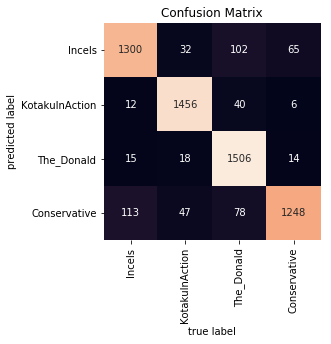

Testing Confusion Matrix:


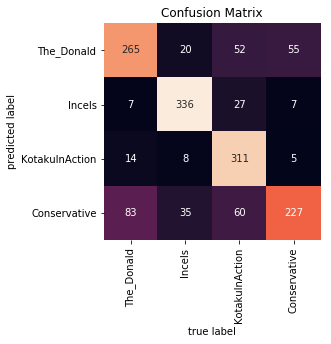

                Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                                    
KotakuInAction    0.109788  0.900860   0.691111           0.653761  0.920118
The_Donald        0.162037  0.749985   0.772109           0.550487  0.560494
Conservative      0.152778  0.791582   0.718157           0.569484  0.676020
Incels            0.068783  0.917870   0.842105           0.777640  0.891247


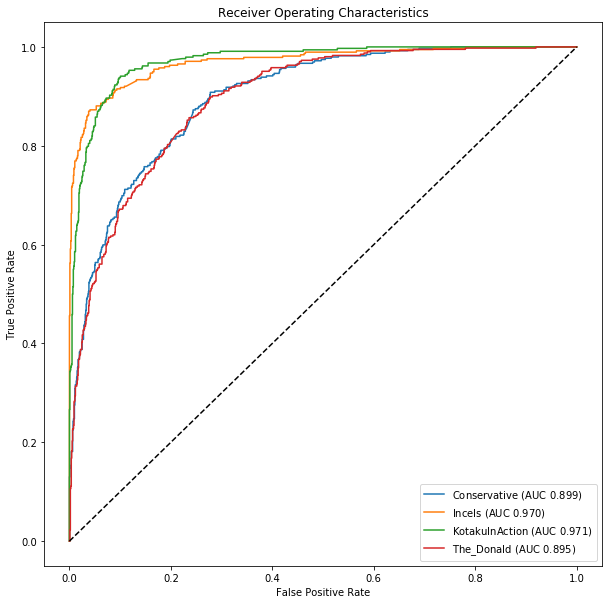

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

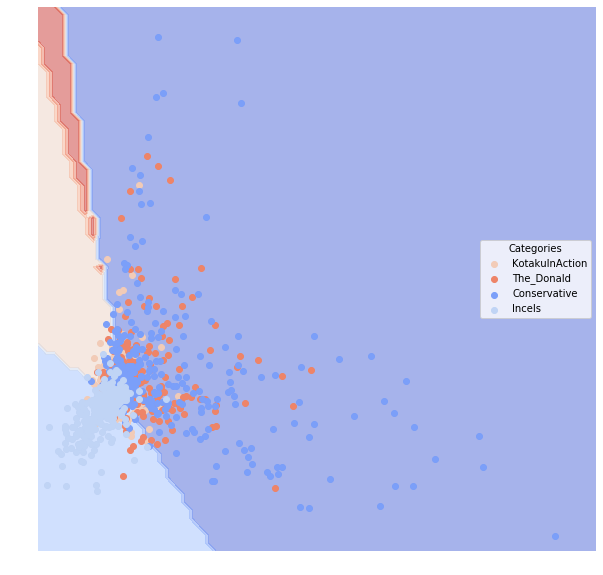

F1-Score: [0.69645204 0.86597938 0.7893401  0.64949928]


In [40]:
MultinomialNB_reddit = sklearn.naive_bayes.MultinomialNB()
clf_outputgen(MultinomialNB_reddit, train_ng_df, test_ng_df, "nbayes")

### Multinomial Logit

In [8]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_ng_df['vect'], axis=0))
train_ng_df['pca'] = [r for r in reduced_data]

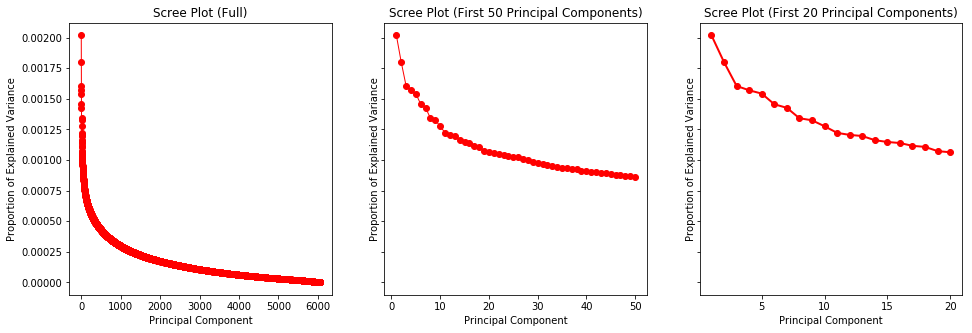

In [9]:
n = len(train_ng_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

In [23]:
train_ng_df['pca_reduced_250'] = train_ng_df['pca'].apply(lambda x: x[:250])

logistic_red = sklearn.linear_model.LogisticRegression()
logistic_red.fit(np.stack(train_ng_df['pca_reduced_250'], axis=0), train_ng_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [24]:
logistic_red.score(np.stack(train_ng_df['pca_reduced_250'], axis=0), train_ng_df['category'])

0.7594183740912095

In [25]:
#PCA
reduced_data_test = pca.transform(np.stack(test_ng_df['vect'], axis=0))
test_ng_df['pca'] = [r for r in reduced_data_test]
test_ng_df['pca_reduced_250'] = test_ng_df['pca'].apply(lambda x: x[:250])

#Test
logistic_red.score(np.stack(test_ng_df['pca_reduced_250'], axis=0), test_ng_df['category'])

0.7533068783068783

In [ ]:
lucem_illud_2020.plotMultiROC(logistic_red, test_ng_df)
lucem_illud_2020.evaluateClassifier(logistic_red, test_ng_df)
lucem_illud_2020.plotConfusionMatrix(logistic_red, test_ng_df)

## Exercise 3: Decision Trees

Training Confusion Matrix:


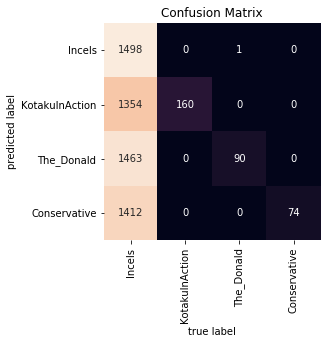

Testing Confusion Matrix:


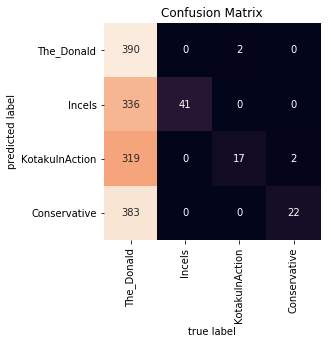

                Error_Rate       AUC  Precision  Average_Precision    Recall
Category                                                                    
KotakuInAction    0.213624  0.524296   0.894737           0.257303  0.050296
The_Donald        0.254630  0.526257   0.916667           0.303101  0.054321
Conservative      0.687831  0.534056   0.273109           0.273039  0.994898
Incels            0.222222  0.554377   1.000000           0.330976  0.108753


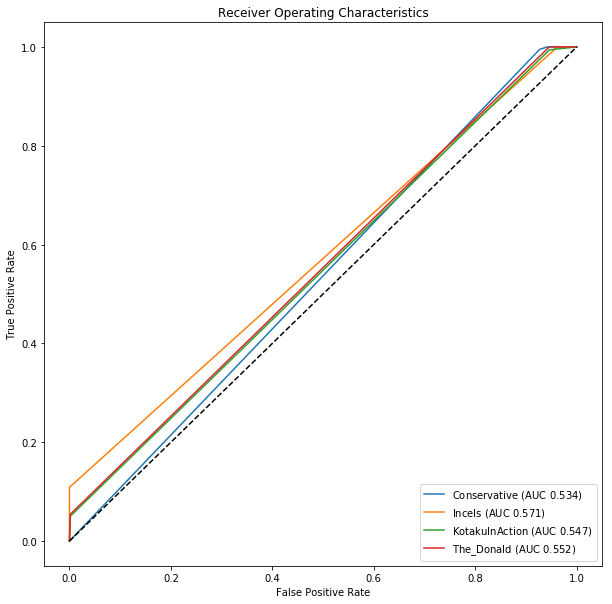

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

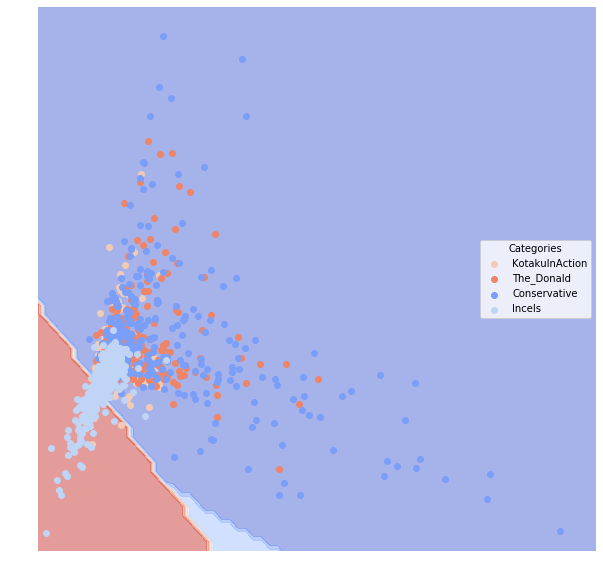

F1-Score: [0.42857143 0.19617225 0.0952381  0.1025641 ]


In [43]:
clf_tree_reddit = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_outputgen(clf_tree_reddit, train_ng_df, test_ng_df, "dtree")

Creating a Random Forest using bagging:

In [ ]:
rftree_reddit = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.
bag_rftree_reddit = sklearn.ensemble.BaggingClassifier(rftree_reddit, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data
clf_outputgen(bag_rftree_reddit, train_ng_df, test_ng_df, "rforest")

In [37]:
lucem_illud_2020.evaluateClassifier(bag, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Incels,0.201720,0.631286,0.916667,0.444077,0.271605
KotakuInAction,0.167328,0.674615,0.876623,0.475478,0.365854
Conservative,0.574074,0.611122,0.288093,0.286259,0.963788
The_Donald,0.226190,0.548813,1.000000,0.323816,0.097625


In [38]:
#Add to df
test_ng_df['nb_predict_rf'] = bag.predict(np.stack(test_ng_df['vect'], axis=0))


print(sklearn.metrics.precision_score(test_ng_df['nb_predict_rf'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict_rf'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict_rf'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.8267565757367819
0.41534391534391535
0.4425407375496433


## Exercise 4: K-Nearest Neighbors

In [ ]:
n_neighbors = 15
weights="uniform"
clf_knearest_reddit = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
clf_outputgen(clf_knearest_reddit, train_ng_df, test_ng_df, "knn_15")

In [40]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform')

In [ ]:
lucem_illud_2020.evaluateClassifier(clf_knearest, train_ng_df)

In [41]:
#Add to df
test_ng_df['nb_predict_knn'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("kNNTesting score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))
print(sklearn.metrics.precision_score(test_ng_df['nb_predict_knn'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict_knn'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict_knn'], test_ng_df['category'], average = 'weighted')) #F-1 measure

kNNTesting score:
0.2533068783068783
0.5777203436102754
0.2533068783068783
0.34320990949583496


/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/software/Anaconda3-5.3.0-el7-x86_64/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


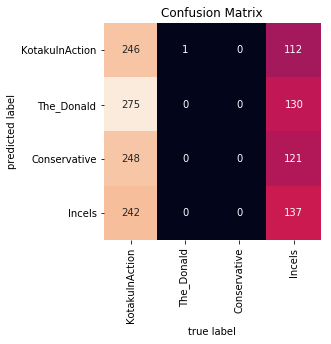

In [42]:
lucem_illud_2020.plotConfusionMatrix(clf_knearest, test_ng_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

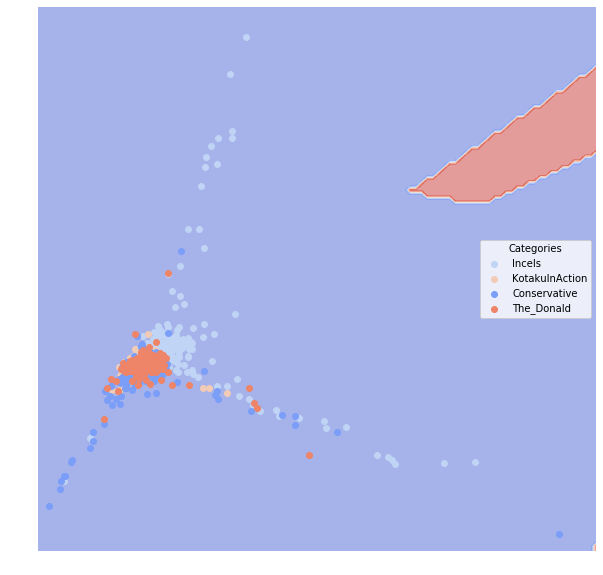

In [43]:
lucem_illud_2020.plotregions(clf_knearest, test_ng_df)

 Articulate how the k-nearest neighbor approach relates to k-means clustering: <<<<>>>>>>>>

## Exercise 5: Neural Nets and SVMs

### Neural Nets -- Multi-layer Perceptron

In [ ]:
clf_nn_reddit = sklearn.neural_network.MLPClassifier()
clf_outputgen(clf_nn_reddit, train_ng_df, test_ng_df, "mlp_nn")

In [45]:
lucem_illud_2020.evaluateClassifier(clf_nn, test_ng_df)

,Error_Rate,AUC,Precision,Average_Precision,Recall
Category,,,,,
Incels,0.078704,0.896146,0.861111,0.767362,0.841975
KotakuInAction,0.094577,0.879639,0.792746,0.699066,0.829268
Conservative,0.182540,0.757547,0.609499,0.476840,0.643454
The_Donald,0.191799,0.732426,0.626781,0.468989,0.580475


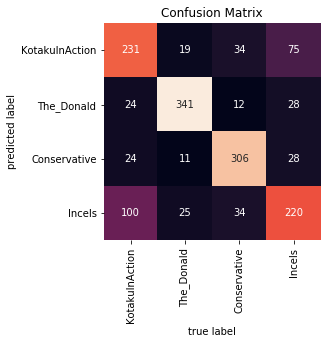

In [46]:
lucem_illud_2020.plotConfusionMatrix(clf_nn, test_ng_df)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

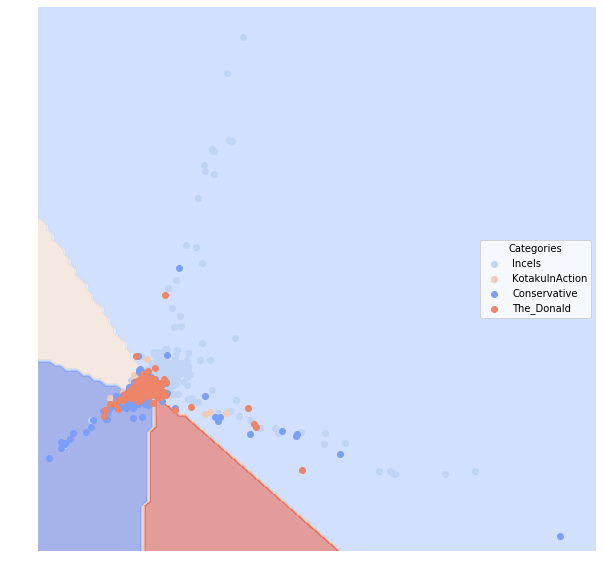

In [47]:
lucem_illud_2020.plotregions(clf_nn, test_ng_df)